# Load Data

In [366]:
import json
import torch
import random
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch import nn
import numpy as np
from scipy.linalg import inv
from torch.optim import Adam

# CLINC150

In [367]:
# Load the dataset
with open("clinc150_uci/data_full.json", "r") as file:
    data = json.load(file)
# Extracting data
train_data = data['train']
val_data = data['val']
test_data = data['test']

oos_train_data = data['oos_train']
oos_val_data = data['oos_val']
oos_test_data = data['oos_test']

# Get sentences and labels
train_sentences = [item[0] for item in train_data]
train_labels = [item[1] for item in train_data]

val_sentences = [item[0] for item in val_data]
val_labels = [item[1] for item in val_data]

test_sentences = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]

oos_train_sentences = [item[0] for item in oos_train_data]
oos_val_sentences = [item[0] for item in oos_val_data]
oos_test_sentences = [item[0] for item in oos_test_data]


# SLURP

In [183]:
# def load_data(file_path):
#     sentences = []
#     scenarios = []
#     with open(file_path, 'r') as file:
#         for line in file:
#             data = json.loads(line)
#             sentence = data.get('sentence', None)
#             scenario = data.get('scenario', None)
#             if sentence is not None and scenario is not None:
#                 sentences.append(sentence)
#                 scenarios.append(scenario)
#     return sentences, scenarios

# # Randomly select one domain to be out of scope
# unique_scenarios = {'alarm', 'audio', 'calendar', 'cooking', 'datetime', 'email', 'general', 'iot', 'lists', 'music', 'news', 'play', 'qa', 'recommendation', 'social', 'takeaway', 'transport', 'weather'}
# oos_scenario = random.choice(list(unique_scenarios))

# # Load data from files
# train_sentences, train_labels = load_data('slurp/dataset/slurp/train.jsonl')
# val_sentences, val_labels = load_data('slurp/dataset/slurp/devel.jsonl')
# test_sentences, test_labels = load_data('slurp/dataset/slurp/test.jsonl')

# # Separate out of scope data
# oos_train_data = [(s, l) for s, l in zip(train_sentences, train_labels) if l == oos_scenario]
# oos_val_data = [(s, l) for s, l in zip(val_sentences, val_labels) if l == oos_scenario]
# oos_test_data = [(s, l) for s, l in zip(test_sentences, test_labels) if l == oos_scenario]

# # Remove out of scope data from original sets
# train_data = [(s, l) for s, l in zip(train_sentences, train_labels) if l != oos_scenario]
# val_data = [(s, l) for s, l in zip(val_sentences, val_labels) if l != oos_scenario]
# test_data = [(s, l) for s, l in zip(test_sentences, test_labels) if l != oos_scenario]

# # Extract sentences and labels
# train_sentences = [item[0] for item in train_data]
# train_labels = [item[1] for item in train_data]

# val_sentences = [item[0] for item in val_data]
# val_labels = [item[1] for item in val_data]

# test_sentences = [item[0] for item in test_data]
# test_labels = [item[1] for item in test_data]

# oos_train_sentences = [item[0] for item in oos_train_data]
# oos_val_sentences = [item[0] for item in oos_val_data]
# oos_test_sentences = [item[0] for item in oos_test_data]

In [223]:
oos_scenario

'cooking'

In [224]:
len(train_sentences)

15000

# Encode Labels

In [368]:
label_encoder = LabelEncoder()
# Fit the label encoder and transform labels to integers
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.fit_transform(val_labels)

In [369]:
# This is just for the transfomer model from ce to be loaded
class TextClassifier(nn.Module):
    def __init__(self, transformer_model, num_labels):
        super(TextClassifier, self).__init__()
        self.transformer = transformer_model
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        # Get the output from the transformer model
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        sentence_embedding = transformer_output.last_hidden_state.max(dim=1).values
        # Forward pass through the classifier layer
        return self.classifier(sentence_embedding)

# Tokenize our sentences and create Dataloaders

In [370]:
pretrained_model_name = "distilroberta-base"
best_ce_model = torch.load("best_ce_model.pth")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
transformer_model = best_ce_model.transformer
#transformer_model = AutoModel.from_pretrained(pretrained_model_name)


In [371]:
tokenized_lengths = [len(tokenizer.encode(sentence, add_special_tokens=True)) for sentence in train_sentences]
max_length = max(tokenized_lengths)
print(f"Max length for tokenizer: {max_length}")

Max length for tokenizer: 37


In [372]:
class TextDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.encodings = tokenizer(sentences, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 2. Create the dataset
train_dataset = TextDataset(train_sentences, encoded_train_labels, tokenizer, max_length)
val_dataset = TextDataset(val_sentences, encoded_val_labels, tokenizer, max_length)

# Define functions to encode our sentences

In [373]:
transformer_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = transformer_model.to(device)
def encode_sentences(model, sentences):
    sentence_embeddings = []

    for sentence in sentences:
        encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Using pooler_output
        sentence_embedding = model_output.last_hidden_state.max(dim=1).values
        sentence_embeddings.append(sentence_embedding.cpu().numpy())

    sentence_embeddings_np = np.concatenate(sentence_embeddings, axis=0)
    return sentence_embeddings_np


In [374]:
test_before_fine = encode_sentences(transformer_model, test_sentences)
oos_test_before_fine = encode_sentences(transformer_model, oos_test_sentences)

In [375]:
test_before_fine

array([[-1.1863111 ,  0.08605812,  0.77187866, ..., -0.01427295,
        -0.16371396,  0.05548896],
       [-0.5211822 , -0.09334413,  0.8267136 , ...,  0.26234072,
         0.52932113, -0.09267343],
       [-0.63188165, -0.06009592,  0.69428515, ..., -0.26533237,
         0.26582038, -0.7362463 ],
       ...,
       [ 0.20671664,  0.00756379, -0.00494014, ...,  2.1312742 ,
         1.0233384 , -0.27835307],
       [ 0.98594856, -0.4223319 ,  0.2975854 , ...,  0.86799765,
         0.8066172 , -1.3825599 ],
       [ 0.6144992 , -0.34527656,  0.43303347, ...,  1.8063234 ,
         1.0846337 , -0.8968681 ]], dtype=float32)

# Define our model

In [423]:
class TextClassifier(nn.Module):
    def __init__(self, transformer_model):
        super(TextClassifier, self).__init__()
        self.transformer = transformer_model
        # Freeze transformer parameters
        for param in self.transformer.parameters():
            param.requires_grad = False
        # Encoder layers
        self.encoder1 = nn.Linear(768, 512)
        self.encoder2 = nn.Linear(512, 256)
        self.encoder3 = nn.Linear(256, 128)
        self.encoder4 = nn.Linear(128, 64)
        self.encoder5 = nn.Linear(64, 32)

        # Decoder layers
        self.decoder1 = nn.Linear(32, 64)   # Adjusted to match the output of encoder4
        self.decoder2 = nn.Linear(64, 128)
        self.decoder3 = nn.Linear(128, 256)
        self.decoder4 = nn.Linear(256, 512)  # New layer to reconstruct the original dimension
        self.decoder5 = nn.Linear(512, 768)

    def forward(self, input_ids, attention_mask):
        # Transformer model output
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        original_embeddings = transformer_output.last_hidden_state.max(dim=1).values

        # Autoencoder forward pass
        x = nn.functional.tanh(self.encoder1(original_embeddings))
        x = nn.functional.tanh(self.encoder2(x))
        x = nn.functional.tanh(self.encoder3(x))
        x = nn.functional.tanh(self.encoder4(x))
        x = nn.functional.tanh(self.encoder5(x))

        x = nn.functional.tanh(self.decoder1(x))
        x = nn.functional.tanh(self.decoder2(x))
        x = nn.functional.tanh(self.decoder3(x))
        x = nn.functional.tanh(self.decoder4(x))
        reconstructed_embeddings = self.decoder5(x)

        return original_embeddings, reconstructed_embeddings



# Define Reconstruction Loss

In [424]:
class ReconstructionLoss(nn.Module):
    def __init__(self):
        super(ReconstructionLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, original_embeddings, reconstructed_embeddings):
        return self.mse_loss(original_embeddings, reconstructed_embeddings)

In [425]:
loss_function = ReconstructionLoss()

# Initiallize everything else we needed

In [426]:
unique_intents = list(set(train_labels)) 
transformer_model.to(device)
model = TextClassifier(transformer_model)
model.to(device)
optimizer = Adam(model.parameters(), lr=6e-4)
training_losses = []
validation_losses = []
batch_size= 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [427]:
num_epochs = 50

# Training Loop!!!

In [428]:
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()  # Zero the gradients
        original_embeddings, reconstructed_embeddings = model(input_ids, attention_mask)
        loss = loss_function(original_embeddings, reconstructed_embeddings)
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss) 

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            original_embeddings, reconstructed_embeddings = model(input_ids, attention_mask)
            loss = loss_function(original_embeddings, reconstructed_embeddings)  # Compute loss
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model
        torch.save(model, 'best_autoencoder_model.pth')
        print(f"Epoch {epoch+1}/{num_epochs}: Lower validation loss found. Model saved.")
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.5e}, Validation Loss: {avg_val_loss:.5e}")

Epoch 1/50: Lower validation loss found. Model saved.
Epoch 1/50, Training Loss: 5.17998e-01, Validation Loss: 7.17309e-01
Epoch 2/50: Lower validation loss found. Model saved.
Epoch 2/50, Training Loss: 4.88548e-01, Validation Loss: 7.10074e-01
Epoch 3/50: Lower validation loss found. Model saved.
Epoch 3/50, Training Loss: 4.79506e-01, Validation Loss: 6.81683e-01
Epoch 4/50: Lower validation loss found. Model saved.
Epoch 4/50, Training Loss: 4.62700e-01, Validation Loss: 6.61709e-01
Epoch 5/50: Lower validation loss found. Model saved.
Epoch 5/50, Training Loss: 4.40243e-01, Validation Loss: 6.50743e-01
Epoch 6/50: Lower validation loss found. Model saved.
Epoch 6/50, Training Loss: 4.14342e-01, Validation Loss: 6.08899e-01
Epoch 7/50: Lower validation loss found. Model saved.
Epoch 7/50, Training Loss: 3.72366e-01, Validation Loss: 5.34862e-01
Epoch 8/50: Lower validation loss found. Model saved.
Epoch 8/50, Training Loss: 3.04827e-01, Validation Loss: 4.42116e-01
Epoch 9/50: Lowe

# Calculate means and covariance matrix

In [413]:
fine_model = torch.load("best_autoencoder_model.pth")
fine_model.eval()  # Put the model in evaluation mode
fine_model = fine_model.to(device)

In [414]:
def encode_sentences(model, sentences):
    # the mode here is TextClassifier

    encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt', 
                               max_length=max_length)
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)
    with torch.no_grad():
        model.eval()  # Ensure the model is in evaluation mode
        original_embeddings, reconstructed_embeddings = model(input_ids, attention_mask)
    return original_embeddings.cpu(), reconstructed_embeddings.cpu()

In [415]:
test_org, test_rec = encode_sentences(fine_model, test_sentences)
oos_test_org, oos_test_rec = encode_sentences(fine_model, oos_test_sentences)

In [416]:
test_before_fine

array([[-1.1863111 ,  0.08605812,  0.77187866, ..., -0.01427295,
        -0.16371396,  0.05548896],
       [-0.5211822 , -0.09334413,  0.8267136 , ...,  0.26234072,
         0.52932113, -0.09267343],
       [-0.63188165, -0.06009592,  0.69428515, ..., -0.26533237,
         0.26582038, -0.7362463 ],
       ...,
       [ 0.20671664,  0.00756379, -0.00494014, ...,  2.1312742 ,
         1.0233384 , -0.27835307],
       [ 0.98594856, -0.4223319 ,  0.2975854 , ...,  0.86799765,
         0.8066172 , -1.3825599 ],
       [ 0.6144992 , -0.34527656,  0.43303347, ...,  1.8063234 ,
         1.0846337 , -0.8968681 ]], dtype=float32)

In [417]:
test_org.numpy()

array([[-1.1863115 ,  0.08605874,  0.77187836, ..., -0.01427282,
        -0.16371399,  0.05548866],
       [-0.5211803 , -0.09334608,  0.8267141 , ...,  0.26234168,
         0.53382564, -0.09267583],
       [-0.63188213, -0.06009676,  0.69428617, ..., -0.25283685,
         0.2966777 , -0.7362462 ],
       ...,
       [ 0.20671675,  0.00756329, -0.00494175, ...,  2.1312733 ,
         1.0233366 , -0.27835152],
       [ 0.98595047, -0.42233205,  0.29758614, ...,  0.8679959 ,
         0.834715  , -1.3825599 ],
       [ 0.61449903, -0.34527716,  0.43303356, ...,  1.8063253 ,
         1.0846331 , -0.8968663 ]], dtype=float32)

In [418]:
test_rec.numpy()

array([[-0.33765972,  0.25519904,  1.1283422 , ...,  0.37902838,
         0.2035414 ,  0.7711807 ],
       [-0.18723644,  0.34792417,  1.013414  , ...,  0.82513696,
         0.6340336 ,  0.5464037 ],
       [-0.16230239,  0.02171887,  0.88215005, ...,  0.6458702 ,
         0.53548324,  0.42258987],
       ...,
       [ 0.6003285 ,  0.5561229 ,  0.57968587, ...,  2.4891248 ,
         1.1913451 ,  0.12809397],
       [ 1.3122379 ,  0.22449526,  0.8860626 , ...,  0.7387148 ,
         1.0063474 , -0.36561292],
       [ 1.0609347 ,  0.38807848,  0.83158994, ...,  1.8756206 ,
         1.0528423 , -0.11338784]], dtype=float32)

In [419]:
test_diffs = torch.mean((test_org - test_rec) ** 2, dim = 1).numpy()
oos_test_diffs = torch.mean((oos_test_org - oos_test_rec) ** 2, dim = 1).numpy()

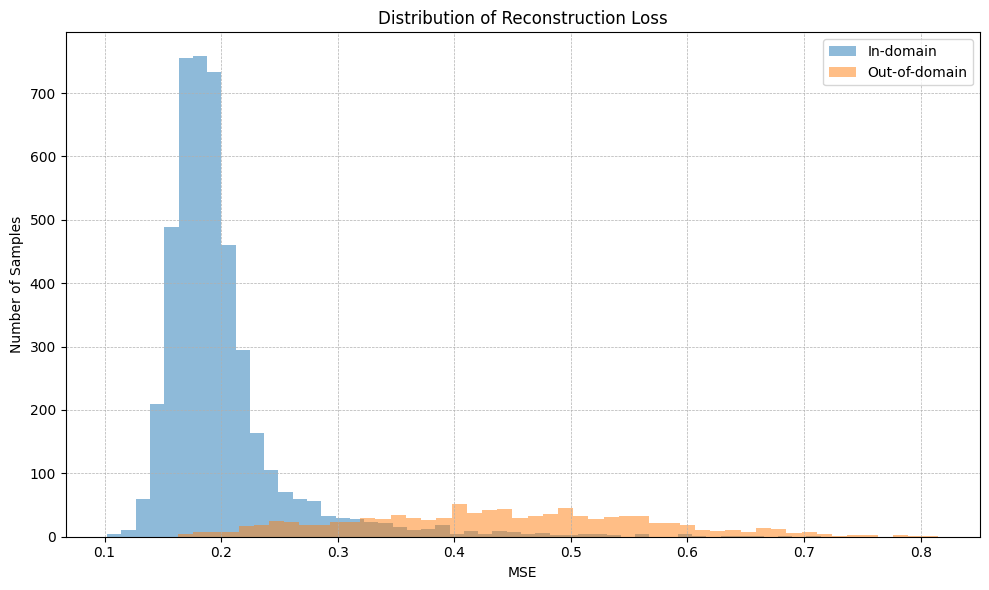

In [420]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_diffs, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_diffs, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Reconstruction Loss')
plt.xlabel('MSE')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [421]:
from sklearn.metrics import average_precision_score

In [422]:
y_true = [0] * len(test_diffs) + [1] * len(oos_test_diffs)

# Combine the scores
y_scores = list(test_diffs) + list(oos_test_diffs)

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)
aupr

0.85845084317626